In [2]:
from __future__ import annotations

from typing import Dict, List
import matplotlib.pyplot as plt
from mme_shuffled_signals import MM_shuffled
from utils import*
from sklearn.metrics import accuracy_score
from tqdm import trange




In [4]:
def run_mc(
    k1: int = 2,
    k2: int = 2,
    N: int = 121,
    flips: int = 50,
    n_trials: int = 100,
    mode: str = "spike",
    seed: int = 42,
    mindist: float = 1 / 50 + 0.02 * (1 / 50),
    T1_2: float = 0.25,
    Fs: float = 30.0,
    snr_grid: List[int] = list(range(0, 51, 10)),
) -> Dict[str, List[List[float]]]:
    """
    Monte-Carlo benchmark for 2-channel “unshuffling” with robust regression.

    Pipeline per trial
    ------------------
    1) Spike locations:
       - Build a jittered, minimum-separation grid on [0,1) with spacing `mindist`.
       - Draw k=k1+k2 locations without replacement and jitter each within ±1% of `mindist`.
       - Split locations into two disjoint sets (channel 1 vs 2).

    2) Amplitudes:
       - Draw i.i.d. amplitudes U[0.5, 1.0] and split by channel.

    3) Simulation:
       - For each channel c∈{1,2}, simulate time series of length N using
         `simulate_noisy_signal` with SNR = `SNR_dB` (in dB) and model `mode`.
       - For `mode="exp"`, the kernel is 1/(α + jω); α is set from the half-life T1/2:
             α = ln(2) * N / (T1_2 * Fs)

    4) Shuffle mask:
       - Initialize q_true ∈ {0,1}^N with exactly `flips` ones at random positions (1…N−1).
       - Observed channels are swapped according to q_true:
             y1_obs = q_true*y1 + (1−q_true)*y2
             y2_obs = q_true*y2 + (1−q_true)*y1
         The permutation-invariant sum x_sum = y1_obs + y2_obs is preserved.

    5) Location estimation (sum signal):
       - Denoise + Prony on x_sum to estimate K=k spike locations:
             Xk_sum, t_est_sum = denoise_and_prony(...)
       - Build time-domain design Ẑ_sum (N×K) via `reconstruction_params`.

    6) Unshuffling via robust regression:
       - Run `MM_shuffled(y1_obs, y2_obs, Ẑ_sum, ...)` to obtain β₁, β₂ and q̂.

    7) Metrics:
       - Normalized MSE (nMSE) per trial is defined assignment-invariantly as
             nMSE = min{ (1/2)[ MSE(clean1, Ẑβ₁)/pow(clean1)
                               + MSE(clean2, Ẑβ₂)/pow(clean2) ],
                          (1/2)[ MSE(clean2, Ẑβ₁)/pow(clean2)
                               + MSE(clean1, Ẑβ₂)/pow(clean1) ] }
         where MSE(a,b) = mean((a−b)²) and pow(clean) = mean(clean²).
       - Weighted accuracy for the shuffle mask uses sample weights
             w = |clean1 − clean2|
         and reports max( Acc(q_true, q̂; w), Acc(1−q_true, q̂; w) )
         to account for the label symmetry.

    Parameters
    ----------
    k1, k2 : int
        Number of spikes in channel 1 and 2, respectively.
    N : int
        Number of time samples per signal.
    flips : int
        Number of positions with q_true=1 (swap) in the mask.
    n_trials : int
        Monte-Carlo repetitions per SNR value.
    mode : {"spike","exp"}
        Observation model passed to `simulate_noisy_signal` and `denoise_and_prony`.
    seed : int
        Seed for NumPy’s Generator.
    mindist : float
        Minimum separation (in “time” units on [0,1)) between candidate grid points.
    T1_2 : float
        Half-life in seconds (used only if mode="exp").
    Fs : float
        Sampling frequency in Hz (used only if mode="exp").
    snr_grid : list of int
        SNR values (in dB) to sweep.

    Returns
    -------
    dict
        {
          "Accuracies": list over SNR of lists over trials of weighted accuracies,
          "MSEs_sum" : list over SNR of lists over trials of assignment-invariant nMSE,
          "snr_grid" : the input SNR grid
        }

    Notes
    -----
    - The design matrix Ẑ_sum contains only location information; amplitudes are
      learned via regression inside `MM_shuffled`.
    - Ensure that external dependencies are imported:
        * `simulate_noisy_signal`, `denoise_and_prony`, `reconstruction_params`
        * `MM_shuffled`
        * `accuracy_score` (scikit-learn) and `trange` (tqdm)
    """
    rng = np.random.default_rng(seed)

    k = k1 + k2
    alpha = np.log(2) * N / (T1_2 * Fs)
    print(alpha)
    Accuracies: List[List[float]] = []
    MSEs_sum: List[List[float]] = []

    for SNR_dB in snr_grid:
        Accuracy_tmp: List[float] = []
        MSEs_sum_tmp: List[float] = []

        for _ in trange(n_trials):
            # jittered grid of all spike times, then split into channels
            all_times = np.sort(
                rng.choice(np.arange(0.5 * mindist, 1, mindist), size=k, replace=False)
                + rng.uniform(-0.01 * mindist, 0.01 * mindist, k)
            )
            idx = np.arange(k, dtype=int)
            p1_idx = np.sort(rng.choice(idx, k1, replace=False))
            p2_idx = np.sort(np.setdiff1d(idx, p1_idx))

            spike_times1 = all_times[p1_idx].tolist()
            spike_times2 = all_times[p2_idx].tolist()

            # amplitudes
            all_amps = rng.uniform(0.5, 1.0, k)
            amplitudes_1 = all_amps[p1_idx].tolist()
            amplitudes_2 = all_amps[p2_idx].tolist()

            # simulate each channel
            clean1, y1_noise, _, _, _, _, _ = simulate_noisy_signal(
                N=N,
                spike_number=k1,
                alpha=alpha,
                SNR_dB=SNR_dB,
                mode=mode,
                spike_times=spike_times1,
                amplitudes=amplitudes_1,
            )
            clean2, y2_noise, _, _, _, _, _ = simulate_noisy_signal(
                N=N,
                spike_number=k2,
                alpha=alpha,
                SNR_dB=SNR_dB,
                mode=mode,
                spike_times=spike_times2,
                amplitudes=amplitudes_2,
            )

            # shuffle mask and observations
            q_true = np.zeros(N, float)
            flip_positions = rng.choice(np.arange(1, N, dtype=int), flips, replace=False)
            q_true[np.sort(flip_positions)] = 1.0

            y1_obs = q_true * y1_noise + (1.0 - q_true) * y2_noise
            y2_obs = q_true * y2_noise + (1.0 - q_true) * y1_noise
            x_sum = y1_obs + y2_obs

            # denoise + Prony on the sum (perm-invariant) to get locations
            Xk_sum, t_est_sum = denoise_and_prony(
                signal=x_sum, alpha=alpha, K=k, L=(N - 1) // 2, mode=mode
            )

            # build design
            Z_hat_sum = reconstruction_params(
                Xk=Xk_sum, t_est=t_est_sum, N=N, alpha=alpha, mode=mode
            )

            # robust MM-based estimation for 2-channel unshuffling
            b1, b2, _, _, q_hat, losses = MM_shuffled(
                y1_obs, y2_obs, Z_hat_sum, outeriter=5, bdp=0.5
            )

            # assignment-invariant normalized MSE
            mse11 = 0.5 * (
                np.mean((clean1 - Z_hat_sum @ b1) ** 2) / np.mean(clean1 ** 2)
                + np.mean((clean2 - Z_hat_sum @ b2) ** 2) / np.mean(clean2 ** 2)
            )
            mse21 = 0.5 * (
                np.mean((clean2 - Z_hat_sum @ b1) ** 2) / np.mean(clean2 ** 2)
                + np.mean((clean1 - Z_hat_sum @ b2) ** 2) / np.mean(clean1 ** 2)
            )
            mse_sum = min(mse11, mse21)
            MSEs_sum_tmp.append(mse_sum)

            # weighted accuracy for q (label-swap invariant)
            w = np.abs(clean1 - clean2)
            acc1 = accuracy_score(q_true, q_hat, sample_weight=w)
            acc2 = accuracy_score(1.0 - q_true, q_hat, sample_weight=w)
            Accuracy_tmp.append(max(acc1, acc2))

        Accuracies.append(Accuracy_tmp)
        MSEs_sum.append(MSEs_sum_tmp)
        print(
            f"SNR={SNR_dB:2d} dB | Acc={np.mean(Accuracy_tmp):.3f} | nMSE={np.median(MSEs_sum_tmp):.3e}"
        )

    return {"Accuracies": Accuracies, "MSEs_sum": MSEs_sum, "snr_grid": snr_grid}


# example call:
results = run_mc(k1=2, k2=2, N=121, flips=40, n_trials=100, mode="spike")

11.182774513033785


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


SNR= 0 dB | Acc=0.696 | nMSE=8.250e-01


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


SNR=10 dB | Acc=0.829 | nMSE=2.229e-01


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


SNR=20 dB | Acc=0.954 | nMSE=1.436e-03


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


SNR=30 dB | Acc=0.993 | nMSE=7.441e-05


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


SNR=40 dB | Acc=0.999 | nMSE=8.750e-06


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]

SNR=50 dB | Acc=1.000 | nMSE=8.875e-07


In [3]:
def plot_mc_results(results):
    """
    Plot Monte-Carlo performance curves (accuracy and normalized MSE) vs. SNR.

    Expects a results dictionary as returned by `run_mc`, containing:
        {
          "Accuracies": list over SNR of per-trial weighted accuracies,
          "MSEs_sum"  : list over SNR of per-trial normalized MSE values,
          "snr_grid"  : list of SNR values in dB
        }

    The function computes median and interquartile ranges (IQR: 25th–75th percentile)
    across trials for both accuracy and nMSE, then plots:
        (1) Weighted accuracy vs. SNR (linear y-axis)
        (2) Normalized MSE vs. SNR (log-scale y-axis)

    Each subplot shows:
      • Median curve with markers
      • Shaded IQR region
      • Optional scatter of individual trial results

    Parameters
    ----------
    results : dict
        Dictionary returned by `run_mc` with keys:
            "snr_grid"  → list[int] or array-like of SNR values in dB
            "Accuracies" → list[list[float]], per-SNR trial accuracies
            "MSEs_sum"   → list[list[float]], per-SNR trial normalized MSEs

    Returns
    -------
    None
        Displays a matplotlib figure with two subplots:
            Left  – weighted accuracy vs SNR
            Right – normalized MSE (log-scale) vs SNR

    Notes
    -----
    - Uses median and IQR (25–75%) as robust statistics across trials.
    - All scatter points are semi-transparent to show distribution spread.
    - The nMSE axis is plotted on a log scale for dynamic range visualization.
    - Style: "seaborn-v0_8-whitegrid" for consistent appearance.

    Example
    -------
    >>> results = run_mc(k1=2, k2=2, N=121, flips=40, n_trials=100, mode="spike")
    >>> plot_mc_results(results)
    """
    snr_vals = np.array(results["snr_grid"])
    Accuracies = results["Accuracies"]
    MSEs_sum   = results["MSEs_sum"]

    # --- aggregate statistics ---
    acc_meds = [np.median(a) for a in Accuracies]
    acc_q25  = [np.percentile(a, 25) for a in Accuracies]
    acc_q75  = [np.percentile(a, 75) for a in Accuracies]

    mse_meds = [np.median(m) for m in MSEs_sum]
    mse_q25  = [np.percentile(m, 25) for m in MSEs_sum]
    mse_q75  = [np.percentile(m, 75) for m in MSEs_sum]

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # ---- (1) Weighted accuracy plot ----
    ax[0].plot(snr_vals, acc_meds, 'o-', color='tab:blue', lw=2, label='Median')
    ax[0].fill_between(snr_vals, acc_q25, acc_q75, color='tab:blue', alpha=0.2, label='IQR')
    for s, arr in zip(snr_vals, Accuracies):
        ax[0].scatter([s]*len(arr), arr, color='tab:blue', alpha=0.25, s=10)
    ax[0].set_xlabel("SNR [dB]", fontsize=12)
    ax[0].set_ylabel("Weighted accuracy", fontsize=12)
    ax[0].set_ylim(0, 1.05)
    ax[0].set_title("Unshuffling accuracy vs SNR", fontsize=13)
    ax[0].grid(True, ls=':')
    ax[0].legend(frameon=False)

    # ---- (2) Normalized MSE plot ----
    ax[1].plot(snr_vals, mse_meds, 's-', color='tab:red', lw=2, label='Median')
    ax[1].fill_between(snr_vals, mse_q25, mse_q75, color='tab:red', alpha=0.2, label='IQR')
    for s, arr in zip(snr_vals, MSEs_sum):
        ax[1].scatter([s]*len(arr), arr, color='tab:red', alpha=0.25, s=10)
    ax[1].set_xlabel("SNR [dB]", fontsize=12)
    ax[1].set_ylabel("Normalized MSE", fontsize=12)
    ax[1].set_yscale("log")
    ax[1].set_title("Reconstruction nMSE vs SNR", fontsize=13)
    ax[1].grid(True, which="both", ls=':')
    ax[1].legend(frameon=False)

    plt.tight_layout()
    plt.show()

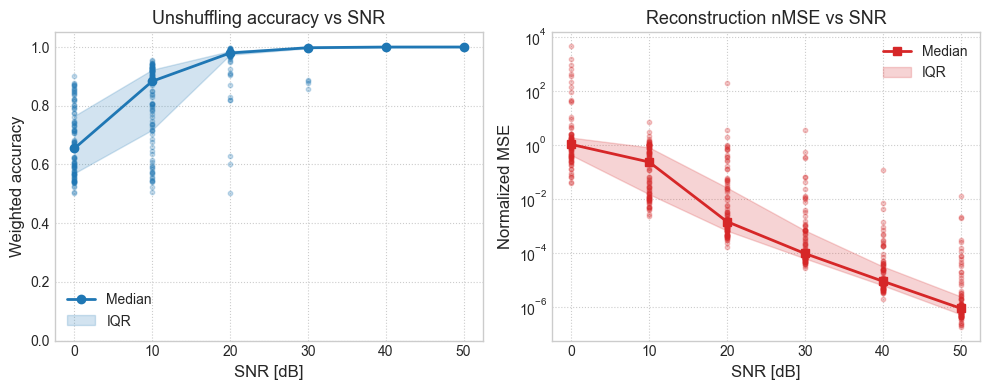

In [6]:
plot_mc_results(results)